In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

### Calibrating the camera

Calibrate the camera based on the calibration images provided in the project (./camera_cal/)

In [2]:
# grab a list of the camera calibration image files
img_list = os.listdir("camera_cal/")

# create a place to hold the average mtx matrix and dist list
mtx_avg = np.zeros((3,3))
dist_avg = np.zeros((1,5))

In [3]:
%matplotlib inline

# function to grab the chessboard corner information from a calibration image. 
# objpoints are for the nx*ny grid
# imgpoints are where the chessboard corners lie in the calibration image pixels
def chessboard_data(img, nx, ny):
    objpoints = []
    imgpoints = []

    # From "Calibrating your camera" section
    objp = np.zeros((ny*nx,3), np.float32)
    objp [:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
    return objpoints, imgpoints

In [4]:
# Learn the camera distortion characteristics based on the input image and knowledge of where
# the chessboard corners lie (objpoints and imgpoints)
# Function comes from "Correcting for Distortion" unit in project's lesson
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:-1], None, None)
    return mtx, dist

# not all of the calibration images pass through the findChessboardCorners function due to 
# some of the inside corners being out of the image frame
# my code will not error out if the input calibration image doesn't have the grid we expect
# but I need to keep track of how many recognized chessboards have been processed
valid_chessboard_count = 0

# iterate through all of the calibration images
for i in range(len((img_list))):
    print ("Calibrating image %d/%d..." % (i+1, len(img_list)))
    img = cv2.imread('./camera_cal/' + img_list[i])
    orig_img = np.copy(img)
    
    # the number of inside corners in x
    nx = 9 
    # the number of inside corners in y
    ny = 6 

    # extract the chessboard grid and their corresponding mapping to the calibration image pixel
    # space with the chessboard_data function from the previous cell
    objpoints, imgpoints = chessboard_data(img, nx, ny)

    # if I get a non-empty list from my chessboard_data...
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        print ("\tERROR: CHESSBOARD NOT FOUND!")
    else:
        # get the mtx matrix and the dist list, add each to their respective running sums
        mtx, dist = cal_undistort(orig_img, objpoints, imgpoints)
        mtx_avg = mtx_avg + mtx
        dist_avg = dist_avg + dist
        valid_chessboard_count += 1

# compute the average of the mtx matrix and the dist list based on the number of chessboard images
# that were successfully processed
mtx_avg = mtx_avg/valid_chessboard_count        
dist_avg = dist_avg/valid_chessboard_count

Calibrating image 1/5...
	ERROR: CHESSBOARD NOT FOUND!
Calibrating image 2/5...
Calibrating image 3/5...
Calibrating image 4/5...
Calibrating image 5/5...


### Image Pipeline

With the camera calibrated, we have the mtx matrix and the dist list to undistort each frame that comes in

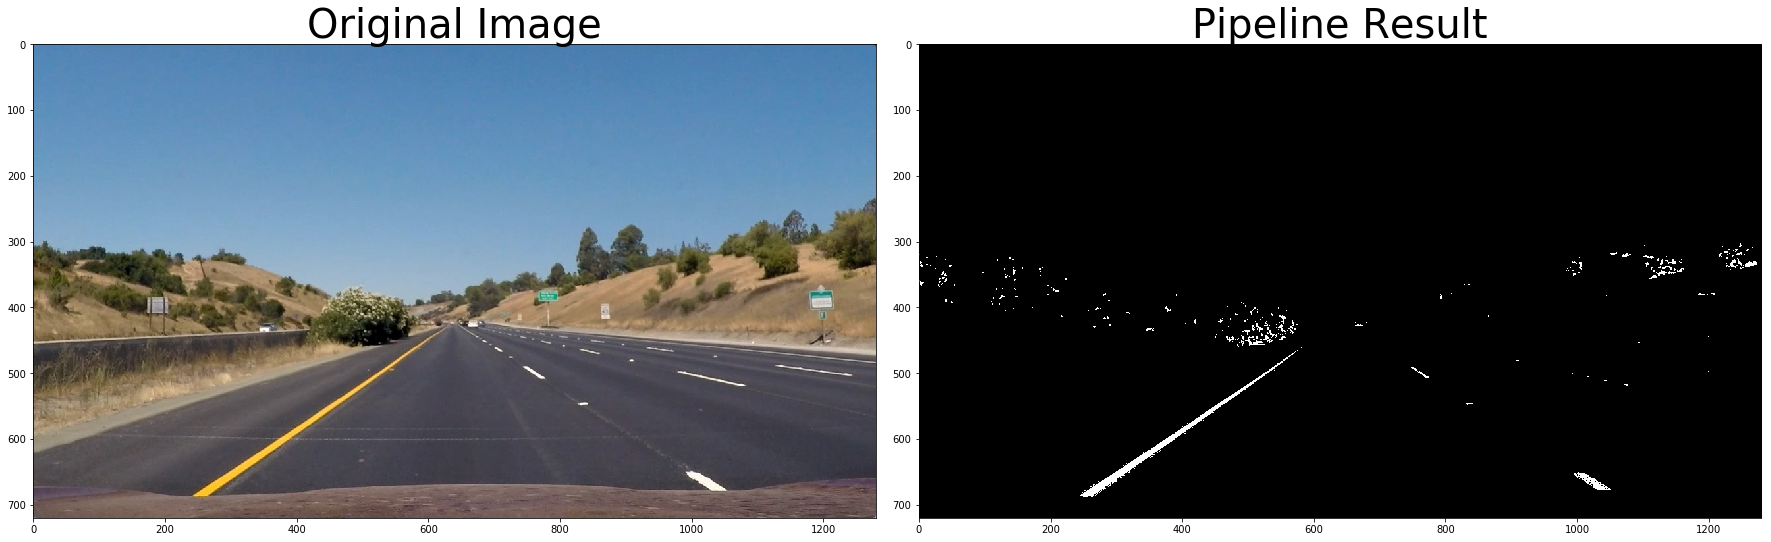

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = img
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.square(sobelx)
    #scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.square(sobely)
    #scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    abs_sobel = np.sqrt(abs_sobelx+abs_sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    #scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    #scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    #abs_sobel = np.sqrt(abs_sobelx+abs_sobely)
    #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(sobelx)
    sbinary1 = np.arctan2(abs_sobely, abs_sobelx)
    sbinary[(sbinary1 >= thresh[0]) & (sbinary1 <= thresh[1])] = 1
    return sbinary

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( s_binary, s_binary, s_binary))
    return color_binary
    
image = mpimg.imread('./test_images/straight_lines1.jpg')
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

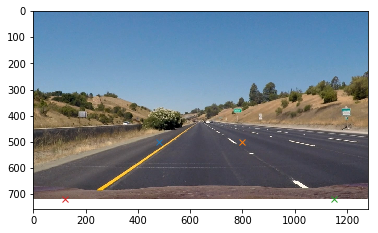

In [15]:
%matplotlib inline

# Read in an image
image = mpimg.imread('./test_images/straight_lines1.jpg')
#undist = cv2.undistort(image, mtx_avg, dist_avg, None, mtx_avg)
plt.imshow(image)
plt.plot(480, 500, 'x')
plt.plot(800, 500, 'x')
plt.plot(1150, 720, 'x')
plt.plot(120, 720, 'x')

#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(undist)
#ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1.0, top=2., bottom=0.9)

(720, 720)


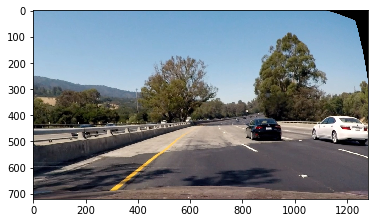

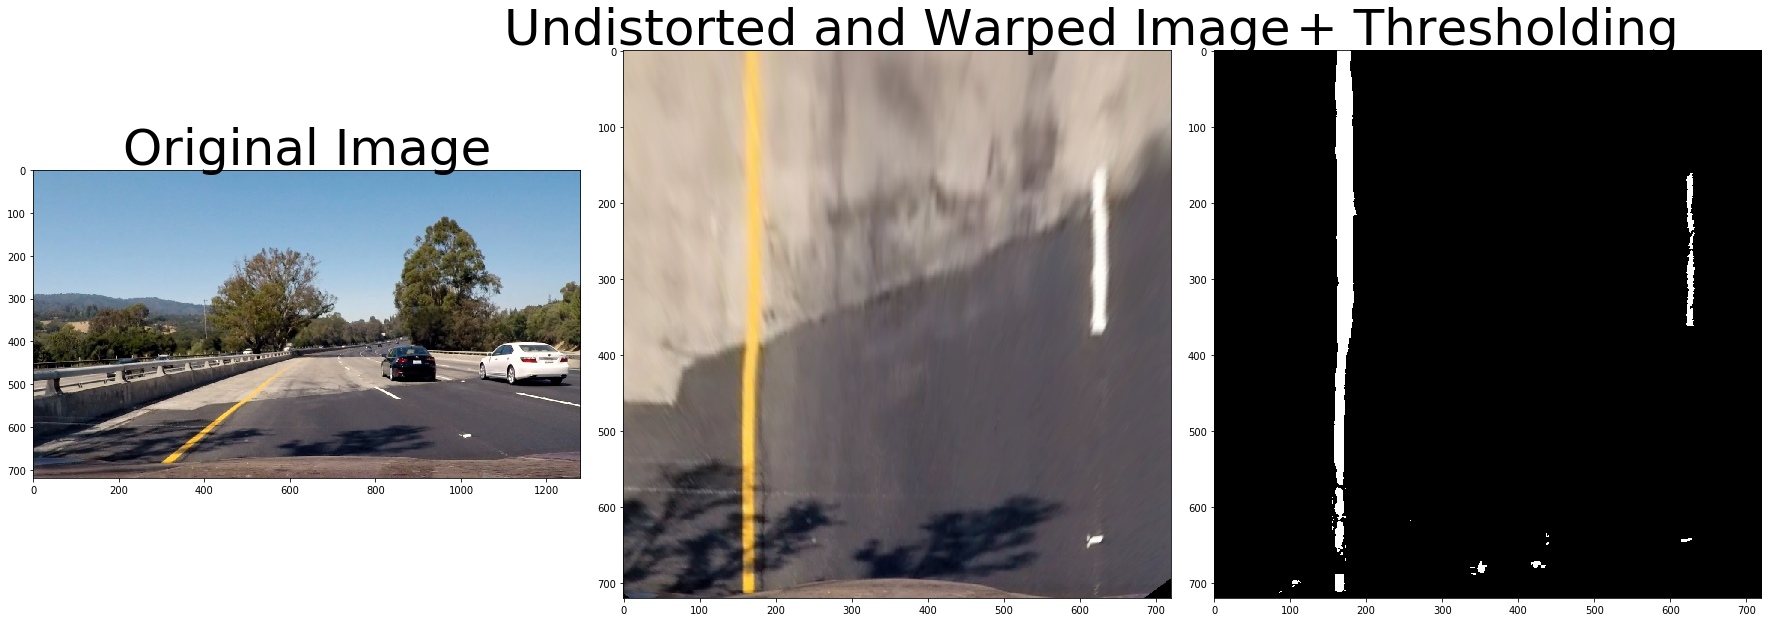

In [34]:
# Function comes from "Undistort and Transform Perspective" unit in the project's lesson
def corners_unwarp(img, corners):  
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.imshow(img)
    nx=2
    
    # If we found corners, draw them! (just for fun)
    #cv2.drawChessboardCorners(checkerboard_img, (nx, ny), corners, ret)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 50 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[0], gray.shape[0])
    print (img_size)

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

image = mpimg.imread('./test_images/test4.jpg')
undist = cv2.undistort(image, mtx_avg, dist_avg, None, mtx_avg)

corners = np.float32(
    [
        [480, 500],
        [800, 500],
        [1150, 650],
        [170, 650]               
     ])

top_down, perspective_M = corners_unwarp(undist, corners)
result = pipeline(top_down)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
ax3.imshow(result)
ax3.set_title('+ Thresholding', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

